In [164]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint

In [165]:
# Function to fetch stock data using yfinance
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    # return (stock_data['Close'].pct_change().dropna() + 1).cumprod() - 1
    return stock_data['Close']

# Define the fixed stock and a list of different stocks to pair with
fixed_stock = '1211.HK'
stocks_to_pair = [
    '0175.HK',
    '9863.HK',
    '2015.HK', 
]  # Add more stocks as needed
name_mapping = {
    '1211.HK': 'BYD',
    '0175.HK': 'Geely',
    '9863.HK': 'Ning Pao',
    '2015.HK': 'Li Xiang',
}

[*********************100%***********************]  4 of 4 completed
C:\Users\owner\AppData\Local\Temp\ipykernel_8716\1697763803.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  price_data = price_data.fillna(method='ffill').dropna()


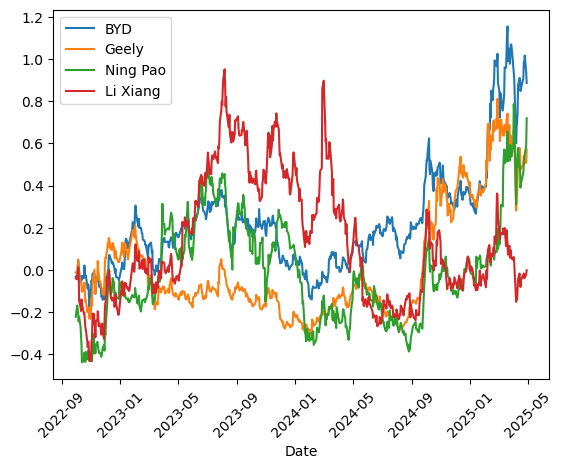

In [166]:
# Fetch historical stock price data and perform analysis for each pair
results = []
start_date = "2021-01-01"
end_date = "2025-04-30"
price_data = fetch_stock_data([fixed_stock]+stocks_to_pair, start_date, end_date)
price_data = price_data.fillna(method='ffill').dropna()
returns = (price_data.pct_change().dropna() + 1).cumprod() - 1
fixed_stock_data = returns[fixed_stock]
plt.plot(fixed_stock_data, label=name_mapping[fixed_stock])
for stock in stocks_to_pair:
    paired_stock_data = returns[stock]

    # cointegration_test = coint(fixed_stock_data, paired_stock_data)
    # cointegration_p_value = cointegration_test[1]

    # Step 1: Regression of paired stock on fixed stock
    X = sm.add_constant(fixed_stock_data)
    model = sm.OLS(paired_stock_data, X).fit()
    residuals = model.resid

    # Step 2: Test residuals for stationarity
    adf_test = sm.tsa.adfuller(residuals)
    adf_p_value = adf_test[1]

    correlation = fixed_stock_data.corr(paired_stock_data)

    results.append({
        'Fixed Stock': name_mapping[fixed_stock],
        'Paired Stock': name_mapping[stock],
        'Cointegration p-value': adf_p_value,
        'Correlation': correlation,
    })

    plt.plot(paired_stock_data, label=name_mapping[stock])

# Create a DataFrame to present the results
results_df = pd.DataFrame(results)

# plt.title('Stock Prices')
plt.xlabel('Date')
plt.xticks(rotation=45)
# plt.ylabel('Price')
plt.legend()
plt.show()

In [167]:
results_df

,Fixed Stock,Paired Stock,Cointegration p-value,Correlation
0,BYD,Geely,0.194188,0.826870
1,BYD,Ning Pao,0.127168,0.643667
2,BYD,Li Xiang,0.306149,0.043665


In [168]:
from statsmodels.tsa.stattools import adfuller

In [169]:
stock1_data = price_data[fixed_stock]
stock2_data = price_data["0175.HK"]
stock1_hand = 500
stock2_hand = 1000

In [170]:
# Scale the data based on shares per hand
stock1_data *= stock1_hand
stock2_data *= stock2_hand

# Calculate the spread between the two stocks
spread = stock1_data - stock2_data

# Perform Augmented Dickey-Fuller (ADF) test to analyze mean-reverting tendencies
adf_test = adfuller(spread.dropna(), maxlag=1)
adf_statistic = adf_test[0]
adf_p_value = adf_test[1]

# Display ADF test results
print("ADF Statistic:", adf_statistic)
print("ADF p-value:", adf_p_value)

ADF Statistic: -0.9263686318037962
ADF p-value: 0.7791648827920107


Completed trades: 29


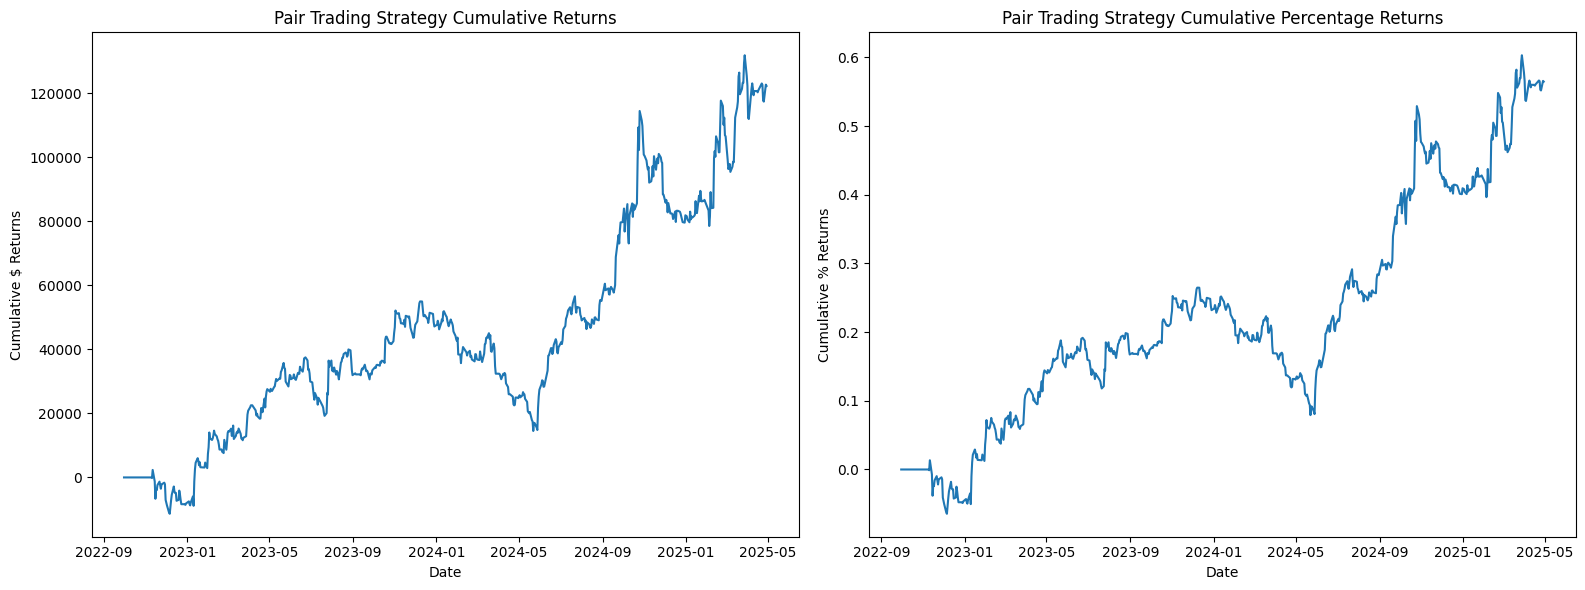

In [ ]:
# Calculate the price ratio between the two stocks
price_ratio = stock1_data / stock2_data

# Calculate z-score of the spread based on a rolling 3-month window
spread_mean = spread.rolling(window=30).mean()
spread_std = spread.rolling(window=30).std()
z_score = (spread - spread_mean) / spread_std

# Define entry and exit thresholds
entry_threshold = 0.2
exit_threshold = 0.1

# Generate signals
signals = np.where(z_score > entry_threshold, -1, np.where(z_score < -entry_threshold, 1, 0))

# Backtest the pair trading strategy
position = 0
pr = price_ratio.iloc[0]
returns = []
pct_returns = []
capital = []
completed_trades = 0
transacted = False
t = 0

for i in range(1, len(signals)):
    cost = 0
    old_position = position
    if signals[i] == 1 and position == 0:
        # Enter long position in stock1 and short position in stock2
        position = 1
        pr = price_ratio.iloc[i]
        transacted = True
        # print("Enter Long Position in Stock1 and Short Position in Stock2 on", stock1_data.index[i])
    elif signals[i] == -1 and position == 0:
        # Enter short position in stock1 and long position in stock2
        position = -1
        pr = price_ratio.iloc[i]
        transacted = True
        # print("Enter Short Position in Stock1 and Long Position in Stock2 on", stock1_data.index[i])
    elif signals[i] == 0 and abs(z_score.iloc[i]) < exit_threshold and position != 0:
        # Exit the position
        position = 0
        completed_trades += 1
        transacted = True
        # print("Exit Position on", stock1_data.index[i])

    if pr < 1:
        a = 1 / pr
        b = 1
    else:
        a = 1
        b = pr
    if transacted:
        t = i
        cost = -(a * stock1_data.iloc[i] + b * stock2_data.iloc[i]) * 0.1105/100
        transacted = False
    
    # Adjust position size based on the price ratio
    if old_position == 1:
        r = a * (stock1_data.iloc[i] - stock1_data.iloc[i-1]) - b * (stock2_data.iloc[i] - stock2_data.iloc[i-1])
    elif old_position == -1:
        r = b * (stock2_data.iloc[i] - stock2_data.iloc[i-1]) - a * (stock1_data.iloc[i] - stock1_data.iloc[i-1])
    else:
        r = 0
    returns.append(r + cost)
    pct_returns.append((r + cost) / (a * stock1_data.iloc[t] + b * stock2_data.iloc[t]))
    capital.append((a * stock1_data.iloc[t] + b * stock2_data.iloc[t])) 

print(f"Completed trades: {completed_trades}")

# # Calculate the Sharpe ratio
# daily_risk_free_rate = (1 + 0.0417)**(1/252) - 1
# excess_daily_returns = pd.Series(pct_returns) - daily_risk_free_rate
# average_excess_return = np.mean(excess_daily_returns)
# std_dev_excess_return = np.std(excess_daily_returns)
# sharpe_ratio = average_excess_return / std_dev_excess_return
# print(f"Annualized Sharpe Ratio: {(np.sqrt(252) * sharpe_ratio):.2f}")

# Calculate cumulative returns
cumulative_returns = np.cumsum(returns)
cumulative_pct_returns = np.cumprod(1 + np.array(pct_returns)) - 1
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(stock1_data.index[1:], cumulative_returns)
axs[0].set_title('Pair Trading Strategy Cumulative Returns')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Cumulative Returns')
axs[0].tick_params(axis='x', labelrotation=45)
axs[1].plot(stock1_data.index[1:], cumulative_pct_returns)
axs[1].set_title('Pair Trading Strategy Cumulative Percentage Returns')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Cumulative % Returns')
axs[1].tick_params(axis='x', labelrotation=45)
axs[2].plot(stock1_data.index[1:], capital)
axs[2].set_title('Capital Used Currently')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Capital (HKD)')
axs[2].tick_params(axis='x', labelrotation=45)

plt.tight_layout()
plt.show()
# Implement risk management and further refine the strategy as needed